# Generate configuration file

Generate hardware and software configuration files
* **Hardware configuration file**: configure the hardware (neurons, synapses, ion channels, monitoring)
* **Software configuration file**: configure the C++ application (monitoring, stimulation, control)

In [11]:
%reload_ext autoreload
%autoreload 2
from configuration.gen_config import gen_config, NetwConfParams

# Configuration file 
CONFIG_NAME = "CA1_cpld_i_0.007335_0.0515_noise_mu_0.06_0.0000001_sigma_0.2_0.05_theta_0.8_wsyn0.4_II_pmax0.9_IE_pmax0.5_EI_pmax0.5"
# CONFIG_NAME = "singleRSnonoise_0.01"
SAVE_PATH   = "./"

# Stimulations
netw_conf = NetwConfParams()
netw_conf.model                     = "custom" # "custom", "single", "connectoid"
netw_conf.emulation_time_s          = 5       # Set emulation time (s)
netw_conf.en_step_stim              = True     # Enable stimulation step
netw_conf.step_stim_delay_ms        = 1000             # Stimulation step delay (ms)
netw_conf.step_stim_duration_ms     = 3000         # Stimulation duration (ms)
netw_conf.local_save_path           = "/home/ubuntu/bioemus/data/" # Save path on target
# netw_conf.en_randomize_hh_params    = True  # Randomizing HH parameters for all neurons
# netw_conf.val_randomize_hh_params   = 0.10  # Randomization coefficient (0.1 -> 10%)
# netw_conf.org_wsyninh               = 1.0   # Organoid synaptic weight inhibition
# netw_conf.org_wsynexc               = 0.22  # Organoid synaptic weight excitatory
# netw_conf.org_pcon_in               = 0.08  # Organoid max connection probability internal
# netw_conf.org_pcon_out              = 0.02  # Organoid max connectiosn probability external
# netw_conf.org_wsyn_in               = 1.0   # Organoid synaptic weight internal
# netw_conf.org_wsyn_out              = 1.0   # Organoid synaptic weight external
# netw_conf.org_inh_ratio             = 0.2   # Organoid inhibitory ratio (0.2->20% of inh)

[hwconfig, swconfig, connection_counts] = gen_config(CONFIG_NAME, netw_conf, SAVE_PATH)

Software configuration file saved at: ./swconfig_CA1_cpld_i_0.007335_0.0515_noise_mu_0.06_0.0000001_sigma_0.2_0.05_theta_0.8_wsyn0.4_II_pmax0.9_IE_pmax0.5_EI_pmax0.5.json
Hardware configuration file saved at: ./hwconfig_CA1_cpld_i_0.007335_0.0515_noise_mu_0.06_0.0000001_sigma_0.2_0.05_theta_0.8_wsyn0.4_II_pmax0.9_IE_pmax0.5_EI_pmax0.5.txt


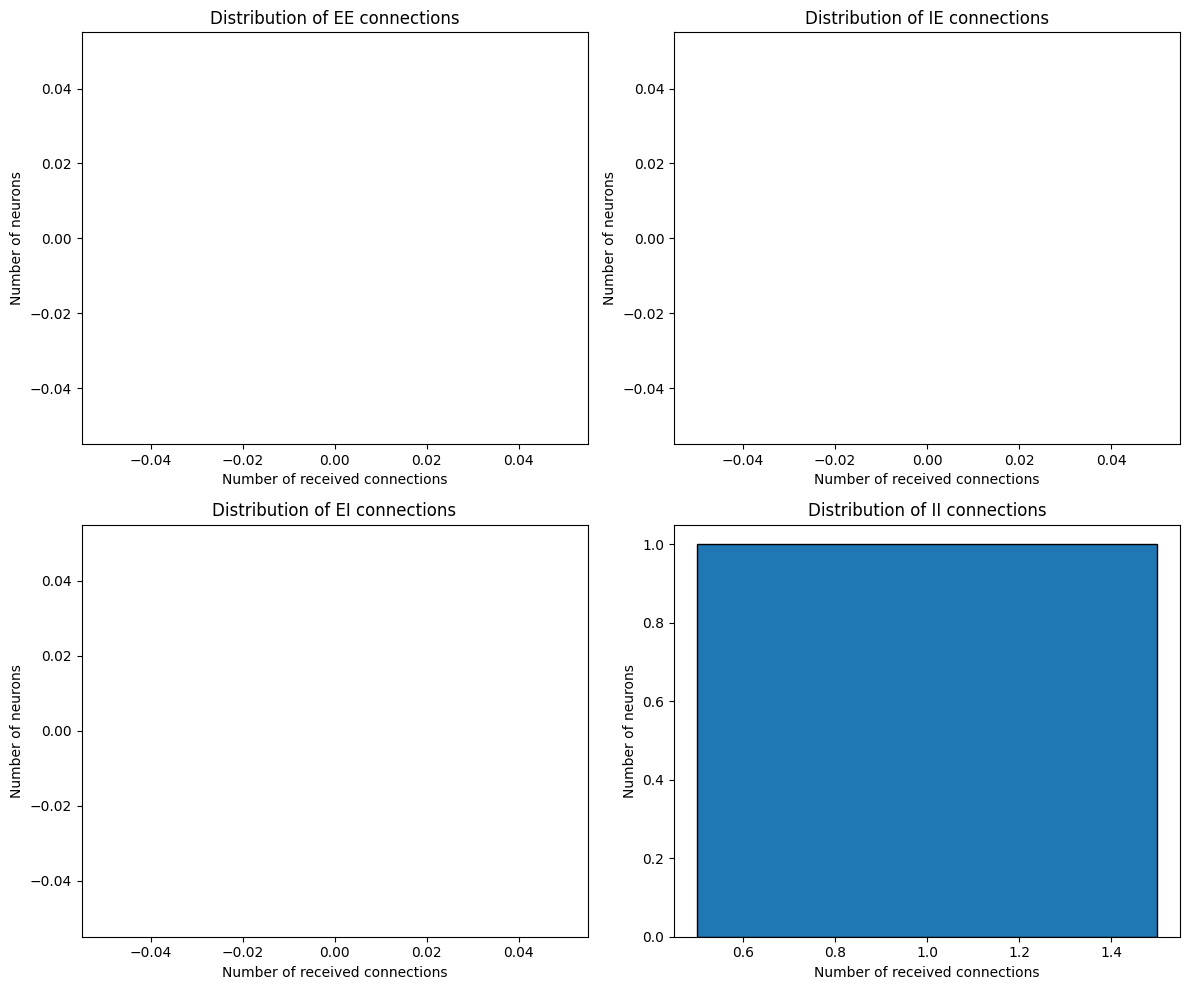

In [12]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
categories = ["EE", "IE", "EI", "II"]

for i, category in enumerate(categories):
    ax = axes[i // 2, i % 2]  # Select subplot position
    
    # Extract the number of connections received per neuron
    received_connections = list(connection_counts[category].values())
    
    # Create a histogram
    ax.hist(received_connections, bins=range(1, max(received_connections, default=1) + 1), edgecolor='black', align='left')
    
    # Set titles and labels
    ax.set_title(f"Distribution of {category} connections")
    ax.set_xlabel("Number of received connections")
    ax.set_ylabel("Number of neurons")

plt.tight_layout()
plt.show()


# Emulate configuration

* Emulate using the configuration files generated

In [12]:
import numpy as np
from emulation.emulate_config import emulate_config

NEURON_LIST   = [i for i in range(4)]
FPGA_EMU      = False
STORE_CONTEXT = False

exact_emu = emulate_config(hwconfig, swconfig, NEURON_LIST, False, STORE_CONTEXT, dtype=np.float64)

if FPGA_EMU:
    fpga_emu = emulate_config(hwconfig, swconfig, NEURON_LIST, True,  STORE_CONTEXT, dtype=np.float32)

Software emulation using exact equations


 19%|█▉        | 31120/159999 [00:04<00:19, 6542.39it/s]


KeyboardInterrupt: 

* Plot emulation

In [11]:
%matplotlib qt
from emulation.plots.SnnPlotter import *

NEURON_TO_DISPLAY       = 0
NEURON_LIST_TO_DISPLAY  = [0,1,2,3]

exact_plotter = SnnPlotter(exact_emu)
# exact_plotter.plotIonRates()
# exact_plotter.plotSynRates()
# exact_plotter.plotIonChanStates(NEURON_TO_DISPLAY)
# exact_plotter.plotCurrents(NEURON_TO_DISPLAY)
exact_plotter.plotVmem(NEURON_LIST_TO_DISPLAY, plot_type='all')
# exact_plotter.plotVmem(NEURON_LIST_TO_DISPLAY, plot_type='comp')
# exact_plotter.plotVmem(NEURON_LIST_TO_DISPLAY, plot_type='subplot')
# exact_plotter.plotRaster()

ModuleNotFoundError: No module named 'sw'

# Monitoring

* Monitor spikes

In [ ]:
import monitoring.spkmon.main as spike_monitor
spike_monitor.main()

* Monitor waves

In [ ]:
# Monitor one wave with GUI
# import monitoring.vmon.main as vmem_monitor
# vmem_monitor.main()

# Monitor multiple waves
from monitoring.waves.waves_mon import waves_mon

TARGET_IP           = "192.168.137.16"
TARGET_PORT         = "5558"
NB_CHANNELS         = 16
NB_DT_PER_TRANSFER  = 190
WINDOW_SIZE_S       = 1
REFRESH_TIME_S      = 0.1

waves_mon(f"tcp//{TARGET_IP}:{TARGET_PORT}", NB_CHANNELS, NB_DT_PER_TRANSFER, WINDOW_SIZE_S, REFRESH_TIME_S)

* External stimulation

In [ ]:
import monitoring.ext_stim.main as external_stim
external_stim.main()

# Analysis

* Raster

In [11]:
%matplotlib qt
from analysis.draw_raster import draw_raster
from analysis.extract_spikes import extract_spikes
from analysis.spike_analysis import spike_analysis
from analysis.burst_analysis import burst_analysis
import pandas as pd

path        = "raster.csv"
#RASTER_LIST    = [f"{1}"] #[f"single{i}" for i in range(1,4+1)]
REC_DURATION_S = 30
SAVE_FIGS      = True

# draw_raster(DIRPATH, SAVE_FIGS)

x = []
y = []
delimiter = ";"
spikes  = pd.read_csv(path, sep=delimiter)
x.append(spikes['time'])
y.append(spikes['neuron_id'])    

fig = plt.figure("Raster plot")

FONTSIZE = 12
plt.subplot(1,1,1)
plt.scatter(x*1e-3, y, s=1, marker='.', color='black')
plt.ylabel('Neuron index', fontsize=FONTSIZE)
plt.xlabel('Time (s)', fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.show()

# tstamp_list = extract_spikes(DIRPATH, RASTER_LIST, REC_DURATION_S)
# spike_analysis(RASTER_LIST, tstamp_list, REC_DURATION_S)
# burst_analysis(RASTER_LIST, tstamp_list)

FileNotFoundError: [Errno 2] No such file or directory: 'raster.csv'

* Waveforms

In [2]:
raster_list = ["raster.csv"]
for i in range(len(raster_list)):
    spikes  = pd.read_csv(raster_list[i], sep=";")
    print(spikes.columns)
    x.append(spikes[0])
    # y.append(spikes['neuron_id'])    

#     fig = plt.figure("Raster plot")
# for i in range(len(raster_list)):
#     plt.subplot(len(raster_list),1,i+1)
#     plt.scatter(x[i]*1e-3, y[i], s=1, marker='.', color='black')
#     plt.ylabel('Neuron index', fontsize=FONTSIZE)
#     plt.xlabel('Time (s)', fontsize=FONTSIZE)
#     plt.yticks(fontsize=FONTSIZE)
#     plt.xticks(fontsize=FONTSIZE)
#     plt.title(raster_list[i])
# plt.show()
    

# fig.savefig('raster.tiff'.format('_'.join(raster_list)), dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

NameError: name 'pd' is not defined

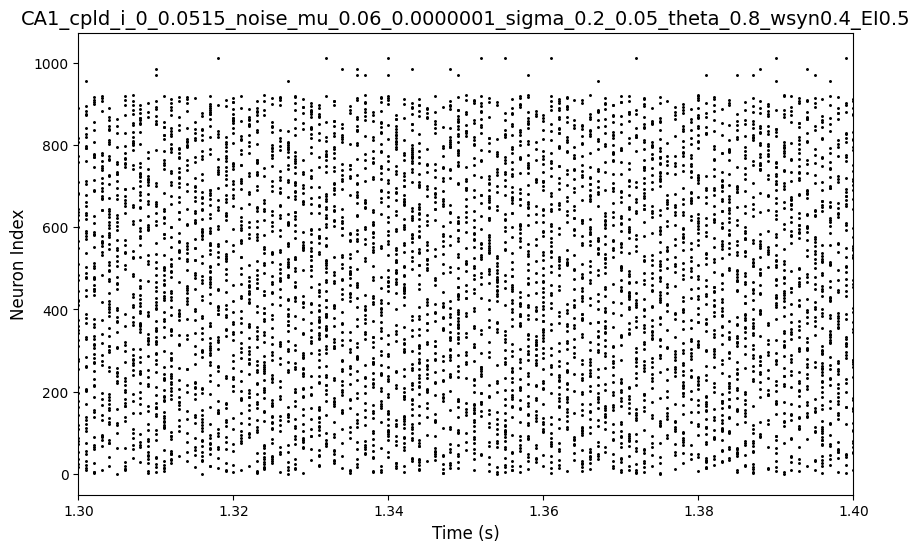

In [35]:
import pandas as pd
import matplotlib.pyplot as plt


csv_file = "/Users/Arianna/Documents/RT-HippoNeuroStim/raster.csv"
delimiter = ';'

# Read the CSV file
spikes = pd.read_csv(csv_file, sep=delimiter, header=None, names=['time', 'neuron_id'])

# Create the plot
plt.figure("Raster plot", figsize=(10, 6))
plt.scatter(spikes['time'] * 1e-3, spikes['neuron_id'], s=5, color='black', marker='.')
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Neuron Index", fontsize=12)
plt.title(CONFIG_NAME, fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim([1.3, 1.4])

# Save and show the plot
plt.savefig(CONFIG_NAME+".jpg", dpi=600, format="jpg", pil_kwargs={"compression": "jpg"})
plt.show()

In [ ]:
%matplotlib qt
from analysis.draw_waves import draw_waves

DIRPATH        = "data/"
WAVE_LIST      = ["test1", "test2"]
PLOT_TIME_S    = 0.1
SEL_NRN        = [i for i in range(2)] # up to MAX_NB_NEURONS_WAVES_MON
SAVE_FIGS      = False

draw_waves(DIRPATH, WAVE_LIST, PLOT_TIME_S, SEL_NRN)


f(I) curves

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data points (Intensity, Frequency)
data_points = np.array([
    [0.007, 30],
    [0.008, 90]
    [0.01, 110],
    [0.02, 250],
    [0.03, 300],
])

# Extracting Intensity and Frequency
intensity = data_points[:, 0]
frequency = data_points[:, 1]

# Plotting the F-I curve
plt.figure(figsize=(8, 6))
plt.plot(intensity, frequency, marker='o', linestyle='-', color='b', label='F-I Curve')
plt.title('Frequency-Intensity (F-I) Curve')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Dati di esempio
i = np.array([ 0.007, 0.01,   0.02,  0.03])
f = np.array([30,     110,    250,   300, ])

# Creazione di una curva interpolata
i_new = np.linspace(i.min(), i.max(), 300)  # Genera nuovi punti i per una curva più liscia
spl = make_interp_spline(i, f, k=3)  # k=3 per spline cubica
f_smooth = spl(i_new)

# Tracciamento dei dati originali e della curva interpolata
plt.figure(figsize=(8, 6))
plt.plot(i, f, 'o', label='Dati originali')
plt.plot(i_new, f_smooth, '-', label='Curva interpolata')
plt.xlabel('i_stim (mA/cm2)')
plt.ylabel('f (Hz)')
plt.title('Inhibitory f(I)')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
#Inhibitory
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_splin

i = np.array([0.048, 0.05,  0.053, 0.055,  0.06, 0.07])
f = np.array([20,    30,    80,   110,    180, 280 ])

# Creazione di una curva interpolata
i_new = np.linspace(i.min(), i.max(), 300)  # Genera nuovi punti i per una curva più liscia
spl = make_interp_spline(i, f, k=3)  # k=3 per spline cubica
f_smooth = spl(i_new)

# Tracciamento dei dati originali e della curva interpolata
plt.figure(figsize=(8, 6))
plt.plot(i, f, '', label='Dati originali')
plt.plot(i_new, f_smooth, '-', label='Curva interpolata')
plt.xlabel('i_stim (mA/cm2)')
plt.ylabel('f (Hz)')
plt.title('Inhibitory f(I)')
plt.legend()
plt.grid(True)
plt.show()

ImportError: cannot import name 'make_interp_splin' from 'scipy.interpolate' (c:\Users\Arianna\.conda\envs\bioemus\Lib\site-packages\scipy\interpolate\__init__.py)

In [81]:
#Excitatory
i = np.array([0.048, 0.049,   0.05,  0.06])
f = np.array([200,    210,    220,   420])

# Creazione di una curva interpolata
i_new = np.linspace(i.min(), i.max(), 300)  # Genera nuovi punti i per una curva più liscia
spl = make_interp_spline(i, f, k=3)  # k=3 per spline cubica
f_smooth = spl(i_new)

# Tracciamento dei dati originali e della curva interpolata
plt.figure(figsize=(8, 6))
plt.plot(i, f, 'r', label='Dati originali')
plt.plot(i_new, f_smooth, '-', label='Curva interpolata')
plt.xlabel('i_stim (mA/cm2)')
plt.ylabel('f (Hz)')
plt.title('Excitatory f(I)')
plt.legend()
plt.grid(True)
plt.show()

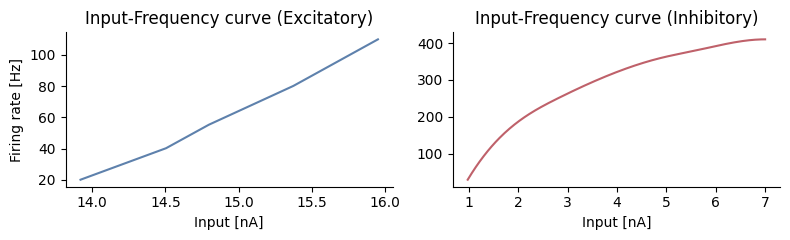

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.legend as mlegend
from scipy.interpolate import make_interp_spline

def get_legend_handles_labels(self, legend_handler_map=None):
    """
    Return handles and labels for legend

    ``ax.legend()`` is equivalent to ::

        h, l = ax.get_legend_handles_labels()
        ax.legend(h, l)
    """
    # pass through to legend.
    handles, labels = mlegend._get_legend_handles_labels(
        [self], legend_handler_map)
    return handles, labels

#FS
i_i = np.array([ 0.007, 0.01,   0.02,   0.035, 0.04, 0.045, 0.05])*14e-5*1e6 # 14e-5 cm^2 is the FS surface area  1e6 to convert from mA to nA
f_i = np.array([30,     110,    250,    360, 380, 400, 410])

#RS after adaptation
# i_e = np.array([ 0.048, 0.049, 0.05, 0.051, 0.053,  0.055])*29e-5*1e6 #, 0.06, 0.07   29e-5 cm^2 is the RS surface area  1e6 to convert from mA to nA
# f_e = np.array([ 20,   30,   40,    55,  80 ,   110]) #,   180,  280

# RS before adaptation
i_e = np.array([ 0.048, 0.049, 0.05, 0.051, 0.053,  0.055])*29e-5*1e6 #, 0.06, 0.07   29e-5 cm^2 is the RS surface area  1e6 to convert from mA to nA
f_e = np.array([ 5000,   30,   40,    55,  80 ,   110]) #,   180,  280


# Inhibitory interpolation
i_i_new = np.linspace(i_i.min(), i_i.max(), 300)  # Genera nuovi punti i_i per una curva più liscia
spl = make_interp_spline(i_i, f_i, k=3)  # k=3 per spline cubica
f_i_smooth = spl(i_i_new)

# Excitatory interpolation
i_e_new = np.linspace(i_e.min(), i_e.max(), 300)  # Genera nuovi punti i_i per una curva più liscia
spl = make_interp_spline(i_e, f_e, k=1)  # k=3 per spline cubica
f_e_smooth = spl(i_e_new)

fig, axes = plt.subplots(1, 2, figsize=(8, 2.5))
c_inh = '#bf616a'
c_exc = '#5e81ac'

# Excitatory plot
# axes[0].plot(i_e, f_i, 'o', label='Dati originali')
axes[0].plot(i_e_new, f_e_smooth, c_exc, label='Excitatory')
axes[0].set_xlabel('Input [nA]')
axes[0].set_ylabel('Firing rate [Hz]')
axes[0].set_title('Input-Frequency curve (Excitatory)')
# axes[0].legend()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
#axes[0].grid(True)

# Inhibitory plot
# axes[1].plot(x, y, 'o', label='Dati originali')
axes[1].plot(i_i_new, f_i_smooth, c_inh, label='Inhibitory')
axes[1].set_xlabel('Input [nA]')
# axes[1].set_ylabel('Firing rate [Hz]')
axes[1].set_title('Input-Frequency curve (Inhibitory)')
# axes[1].legend()
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
#axes[1].grid(True)

# Legends
# lines_labels = [get_legend_handles_labels() for ax in [axes[0], axes[1]]]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# axes[0].legend(lines, labels, loc='upper left')

# Mostrare il grafico
plt.tight_layout()
plt.show()

Noise simulation

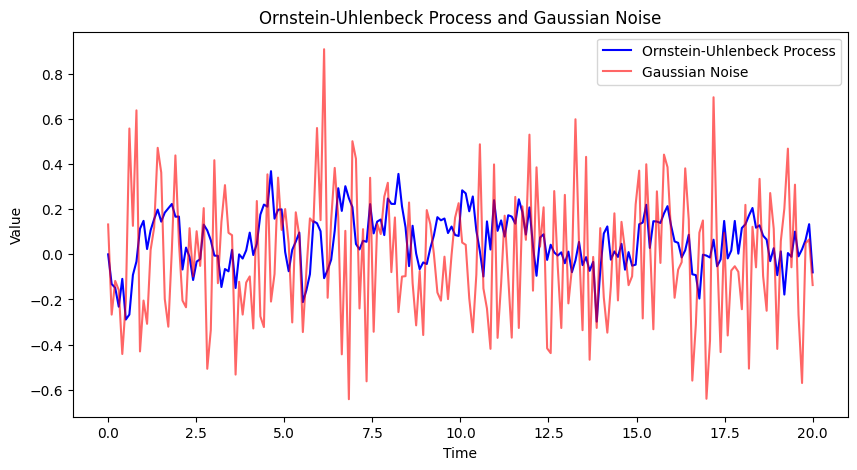

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri del processo Ornstein-Uhlenbeck
theta = 5.0  # Velocità di ritorno
mu = 0.048       # Valore medio
sigma = 0.3    # Intensità del rumore
dt = 0.1      # Passo temporale
T = 20          # Tempo totale
N = int(T / dt)  # Numero di passi
t = np.linspace(0, T, N)

# Inizializzazione
ou_process = np.zeros(N)
gaussian_noise = np.random.normal(0, sigma, N)

# Simulazione del processo di Ornstein-Uhlenbeck
for i in range(1, N):
    ou_process[i] = ou_process[i-1] + theta * (mu - ou_process[i-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(t, ou_process, label="Ornstein-Uhlenbeck Process", color="blue")
plt.plot(t, gaussian_noise, label="Gaussian Noise", color="red", alpha=0.6)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Ornstein-Uhlenbeck Process and Gaussian Noise")
plt.legend()
plt.show()
